# CS229, Fall 2017
## Problem Set 4: EM, DL & RL

This is my solutions for CS229 - Fall 2017: Machine Learning taught by Andrew Ng.

The material for Problem Set 4 is here: [ps4](https://github.com/nmduonggg/ML-CS229/blob/master/Problem%20Set%204/ps4.pdf)

This notebook contains the solution for __Question 1: Neural Networks: MNIST image classification__

#### Starter code

### Question 1.a)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def cross_entropy(y, y_hat):
    return -np.dot(y.T, np.log2(y_hat))
def get_cost(y, y_hat):
    total = 0
    k,n = y.shape
    for i in range(n):
        ins, pred = y[:, i], y_hat[:, i]
        total += cross_entropy(ins, pred)
    return total / n

#### Derivation for softmax

Consider $x \in R^m$, then the forward propagation is as follows:

$$
\begin{align*}
    &z^{[1]} = W^{[1]}x + b^{[1]} \implies z_i^{[1]} = \sum_j w^{[1]}_{ij}x_j \\
    &a^{[1]} = f_1(z^{[1]}) \implies a_i^{[1]} = \frac{1}{1 + \exp(-z_i^{[1]})} \\
    &z^{[2]} = W^{[2]}a^{[1]} + b^{[2]} => z_i^{[2]} = \sum_j w^{[2]}_{ij}a_j^{[1]} \\
    &a^{[2]} = f_2(z^{[2]}) \implies a_i^{[2]} = \frac{e^{z_i^{[2]}}}{\sum_i e^{z_i^{[2]}}} \\
    \text{Loss function: } \quad &J = -\sum_i y_i \log a_i^{[2]}
\end{align*}
$$

Consider following essential derivations

$$
\begin{align*}
&\frac{\partial a_i^{[2]}}{\partial z_i^{[2]}} = a_i^{[2]}(1 - a_i^{[2]}) \\
&\frac{\partial a_i^{[2]}}{\partial z_j^{[2]}} = -a_i^{[2]}a_j^{[2]} \\
&\frac{\partial J}{\partial a_i^{[2]}} = -\sum_i y_i \frac{1}{a_i^{[2]}}
\end{align*}
$$


In order to implement backpropagation, we calculate $\delta^{[k+1]} = \frac{\partial J}{\partial z^{[k+1]}}$

$$
\begin{align*}
    \frac{\partial J}{\partial z_i^{[2]}} &= \frac{\partial J}{\partial a_i^{[2]}} \frac{\partial a_i^{[2]}}{\partial z_j^{[2]}} \\
    &= -\big(\sum_{i \ne j} y_i \frac{1}{a_i^{[2]}}\big)\big(-a_i^{[2]}a_j^{[2]}\big) - \big(\sum_{i=j}y_i \frac{1}{a_i^{[2]}}\big)a_i^{[2]}(1 - a_i^{[2]}) \\
    &= \sum_{i \ne j} y_ia_j^{[2]} + \sum_{i=j} y_i (a_j^{[2]} - 1) \\
    &= \sum_i y_i a_j^{[2]} - y_j \\
    &= a_j^{[2]} - y_j
\end{align*}
$$

Thus

- $\delta^{[2]} =  a^{[2]} - y$
- $\delta^{[1]} = ({W^{[2]}}^T \delta^{[2]}) \odot f'_1(z^{[1]})$
- $\frac{\partial J}{\partial W^{[k+1]}} = \delta^{[k+1]}{a^{[k]}}^T $
- $\frac{\partial J}{\partial b^{[k+1]}} = \delta^{[k+1]}$

In [12]:
def compute_accuracy(output, labels):
    accuracy = (np.argmax(output,axis=0) == np.argmax(labels,axis=0)).sum() * 1. / labels.shape[1]
    return accuracy

def one_hot_labels(labels):
    one_hot_labels = np.zeros((labels.size, 10))
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    return one_hot_labels

def main():
    np.random.seed(100)
    trainData, trainLabels = readData('data\images_train.csv', 'data\labels_train.csv')
    trainLabels = one_hot_labels(trainLabels)
    p = np.random.permutation(60000)
    trainData = trainData[p,:]
    trainLabels = trainLabels[p,:]

    devData = trainData[0:10000,:]
    devLabels = trainLabels[0:10000,:]
    trainData = trainData[10000:,:]
    trainLabels = trainLabels[10000:,:]

    mean = np.mean(trainData)
    std = np.std(trainData)
    trainData = (trainData - mean) / std
    devData = (devData - mean) / std

    testData, testLabels = readData('data\images_test.csv', 'data\labels_test.csv')
    testLabels = one_hot_labels(testLabels)
    testData = (testData - mean) / std
    
    params = nn_train(trainData, trainLabels, devData, devLabels)
    

    readyForTesting = False
    if readyForTesting:
        accuracy = nn_test(testData, testLabels, params)
        print ('Test accuracy: %f' % accuracy)
        
    return params

In [13]:
def readData(images_file, labels_file):
    x = np.loadtxt(images_file, delimiter=',')
    y = np.loadtxt(labels_file, delimiter=',')
    return x, y

def softmax(x):
    """
    Compute softmax function for input. 
    Use tricks from previous assignment to avoid overflow
    """
    ### YOUR CODE HERE
    lbX = np.max(x, axis = 0)
    denominators = np.sum(np.exp(x - lbX), axis = 0, keepdims = True)
    s = (np.exp(x - lbX)) / denominators
    ### END YOUR CODE
    return s

def sigmoid(x):
    """
    Compute the sigmoid function for the input here.
    """
    ### YOUR CODE HERE
    def normalized_sigmoid(z):
        if z >= 0: return np.exp(z) / (1 + np.exp(z))
        else: return 1 / (1 + np.exp(-z))
    sigmoid_z = np.vectorize(normalized_sigmoid)
    s = sigmoid_z(x)
    ### END YOUR CODE
    return s

def forward_prop(data, labels, params):
    """
    return hidder layer, output(softmax) layer and loss
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    
    ### YOUR CODE HERE
    z1 = W1.dot(data) + b1
    a1 = sigmoid(z1)
    z2 = W2.dot(a1) + b2
    a2 = softmax(z2)
    
    h = np.hstack((z1, a1))
    y = a2
    cost = get_cost(labels, a2)
    ### END YOUR CODE
    return h, y, cost

def backward_prop(data, labels, params):
    """
    return gradient of parameters
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    ### YOUR CODE HERE
    x, h, a2 = data   #h = (z1, a1)
    n = x.shape[1]
    z1 = h[:, :n]
    a1 = h[:, n:]
    delta2 = a2 - labels
    delta1 = (W2.T).dot(delta2) * (sigmoid(z1)*(1- sigmoid(z1)))
    
    gradW2 = delta2.dot(a1.T)
    gradb2 = np.sum(delta2, axis = 1, keepdims = True)
    gradW1 = delta1.dot(x.T)
    gradb1 = np.sum(delta1, axis = 1, keepdims = True)
    ### END YOUR CODE

    grad = {}
    grad['W1'] = gradW1
    grad['W2'] = gradW2
    grad['b1'] = gradb1
    grad['b2'] = gradb2

    return grad

def nn_train(trainData, trainLabels, devData, devLabels):
    (n, m) = trainData.shape
    k = 10     #num of classes
    num_hidden = 300
    learning_rate = 5
    B = 1000
    num_epoches = 30
    params = {}
    
    # Initialize
    
    W1 = np.random.normal(0, 1,(num_hidden, m)).reshape(num_hidden, m)
    W2 = np.random.normal(0, 1,(k, num_hidden)).reshape(k, num_hidden)
    b1 = np.zeros((num_hidden, 1))
    b2 = np.zeros((k, 1))
    params['W1'] = W1
    params['W2'] = W2
    params['b1'] = b1
    params['b2'] = b2
    
    current_cost = 999999999
    cost_epoch_train = np.zeros(num_epoches)
    cost_epoch_dev = np.zeros(num_epoches)
    acc_epoch_train = np.zeros(num_epoches)
    acc_epoch_dev = np.zeros(num_epoches)

    ### YOUR CODE HERE
    for e in range(num_epoches):
        for i in range(0, n, B):
            train_xbatch = trainData[i: i + B, :].T
            train_ybatch = trainLabels[i: i + B, :].T
        
            hidden_layer, output, cost = forward_prop(train_xbatch, train_ybatch, params)
            grad = backward_prop((train_xbatch, hidden_layer, output),train_ybatch, params)

            gradW1 = grad['W1']
            gradW2 = grad['W2']
            gradb1 = grad['b1']
            gradb2 = grad['b2']

            params['W1'] = params['W1'] - learning_rate*gradW1/B
            params['W2'] = params['W2'] - learning_rate*gradW2/B
            params['b1'] = params['b1'] - learning_rate*gradb1/B
            params['b2'] = params['b2'] - learning_rate*gradb2/B

            current_cost = cost
        
        dev_hidden, dev_output, dev_cost = forward_prop(devData.T, devLabels.T, params)
        train_hidden, train_output, train_cost = forward_prop(trainData.T, trainLabels.T, params)
        train_acc = compute_accuracy(train_output, trainLabels.T)
        dev_acc = compute_accuracy(dev_output, devLabels.T)
        
        cost_epoch_dev[e] = dev_cost
        cost_epoch_train[e] = train_cost
        
        acc_epoch_train[e] = train_acc
        acc_epoch_dev[e] = dev_acc
        
        print(f"Epoch {e}: Training cost {train_cost} - Dev cost {dev_cost} -  Training acc {train_acc} - Dev acc {dev_acc}")
        
    plt.figure(figsize = (6, 4))
    plt.plot(np.arange(num_epoches), cost_epoch_train, 'b')
    plt.plot(np.arange(num_epoches), cost_epoch_dev, 'r')
    plt.legend(['Training cost', 'Dev cost'])
    
    plt.figure(figsize = (6,4))
    plt.plot(np.arange(num_epoches), acc_epoch_train, 'b')
    plt.plot(np.arange(num_epoches), acc_epoch_dev, 'r')
    plt.legend(['Training accuracy', 'Dev accuracy'])
    
    plt.plot()
    ### END YOUR CODE

    return params


Epoch 0: Training cost 0.8932605623239389 - Dev cost 1.093935223377649 -  Training acc 0.8679 - Dev acc 0.8505
Epoch 1: Training cost 0.5469841994209012 - Dev cost 0.7730627613833096 -  Training acc 0.90968 - Dev acc 0.8821
Epoch 2: Training cost 0.4121670914427128 - Dev cost 0.6679800698241178 -  Training acc 0.92676 - Dev acc 0.8947
Epoch 3: Training cost 0.3327994307752959 - Dev cost 0.6137453497005925 -  Training acc 0.93868 - Dev acc 0.9009
Epoch 4: Training cost 0.2807987190517828 - Dev cost 0.5765751437448853 -  Training acc 0.94836 - Dev acc 0.9057
Epoch 5: Training cost 0.24387314784096728 - Dev cost 0.5513943468224544 -  Training acc 0.95522 - Dev acc 0.9097
Epoch 6: Training cost 0.21599217423052422 - Dev cost 0.5316207681305786 -  Training acc 0.96024 - Dev acc 0.9113
Epoch 7: Training cost 0.193655432781367 - Dev cost 0.5154949044376793 -  Training acc 0.9645 - Dev acc 0.9145
Epoch 8: Training cost 0.17551337253055121 - Dev cost 0.5025446253200027 -  Training acc 0.9682 - 

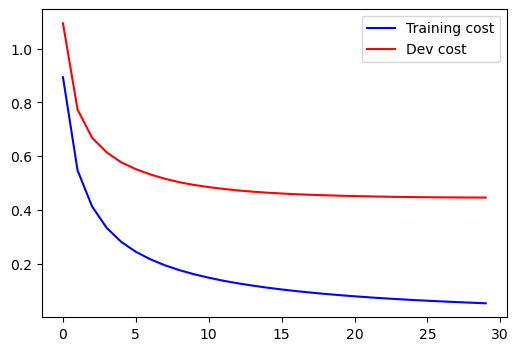

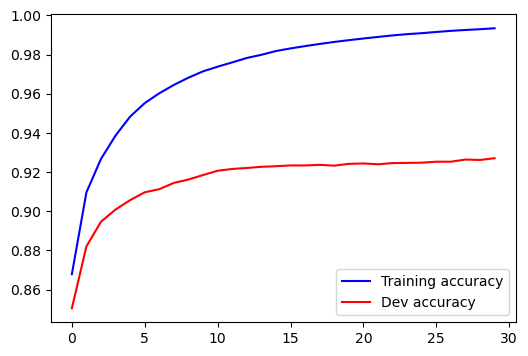

In [14]:
origin_params = main()

### Question 1.b)

$$
\begin{align*}
J &= \frac{1}{B}\sum_{i=1}^B CE(y^{(i)}, a_i^{[2]}) + \lambda (||W^{[1]}||^2 + ||W^{[2]}||^2) \\
\implies \quad \frac{\partial J}{\partial W^{[k+1]}} &= \delta^{[k+1]} {a^{[k]}}^T + \lambda \frac{\partial}{\partial W^{[k+1]}} \big[||W^{[1]}||^2 + ||W^{[2]}||^2\big] \\
 &= \delta^{[k+1]} {a^{[k]}}^T + 2\lambda W^{[k+1]}
\end{align*}
$$

The regularization term has no effect on the bias $b$

In [15]:
def backward_prop(data, labels, params):
    """
    return gradient of parameters
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    lambda_ = 0.0001

    ### YOUR CODE HERE
    x, h, a2 = data   #h = (z1, a1)
    n = x.shape[1]
    z1 = h[:, :n]
    a1 = h[:, n:]
    delta2 = a2 - labels
    delta1 = (W2.T).dot(delta2) * (sigmoid(z1)*(1- sigmoid(z1)))
    
    gradW2 = delta2.dot(a1.T) + 2*lambda_*W2
    gradb2 = np.sum(delta2, axis = 1, keepdims = True)
    gradW1 = delta1.dot(x.T) + 2*lambda_*W1
    gradb1 = np.sum(delta1, axis = 1, keepdims = True)
    ### END YOUR CODE

    grad = {}
    grad['W1'] = gradW1
    grad['W2'] = gradW2
    grad['b1'] = gradb1
    grad['b2'] = gradb2

    return grad

Epoch 0: Training cost 0.8915383317660335 - Dev cost 1.0915299239630143 -  Training acc 0.86826 - Dev acc 0.8524
Epoch 1: Training cost 0.5458874241476921 - Dev cost 0.7751034479745877 -  Training acc 0.90836 - Dev acc 0.8827
Epoch 2: Training cost 0.4101791498625167 - Dev cost 0.6694356052243867 -  Training acc 0.92728 - Dev acc 0.8927
Epoch 3: Training cost 0.33231906791737015 - Dev cost 0.6130988326613587 -  Training acc 0.93904 - Dev acc 0.9014
Epoch 4: Training cost 0.28045228164994185 - Dev cost 0.5754684538257188 -  Training acc 0.94834 - Dev acc 0.9069
Epoch 5: Training cost 0.24353957252774078 - Dev cost 0.5495914858271286 -  Training acc 0.95542 - Dev acc 0.9102
Epoch 6: Training cost 0.215867402565927 - Dev cost 0.5282237737326306 -  Training acc 0.96016 - Dev acc 0.914
Epoch 7: Training cost 0.193541527050044 - Dev cost 0.5112196396923347 -  Training acc 0.96448 - Dev acc 0.9153
Epoch 8: Training cost 0.17520766696960408 - Dev cost 0.498125906116888 -  Training acc 0.96824 

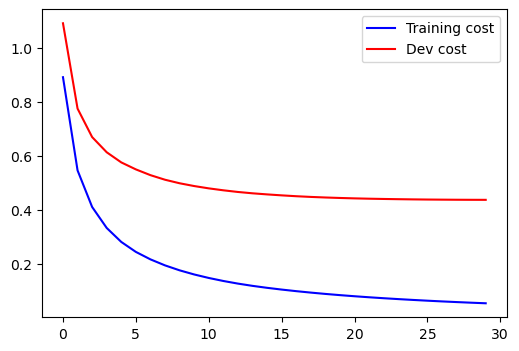

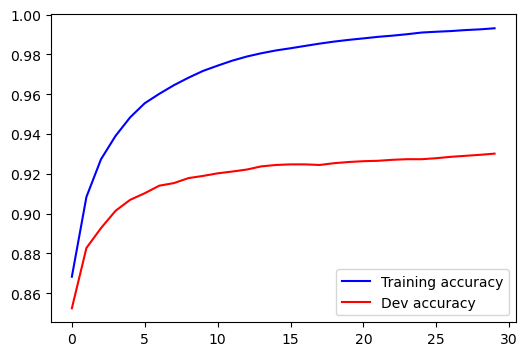

In [16]:
regularized_params = main()

#### Remark

- There is not significant difference assumed in regularized version versus non-regularized one. However, we can see that the difference between training loss and dev loss in regularized version seems to be closer than the non-regularized version
- The numberical results shown on some last epoches also idicate the fact that by adding some regularization term into loss, training loss seems to be higher and dev loss seems to be lower comparing to the non-regularized one.

In [20]:
np.save('non_regularized_params', origin_params)

In [21]:
np.save('regularized_params', regularized_params)

### Question 1.c)



In [22]:
def nn_test(data, labels, params):
    h, output, cost = forward_prop(data, labels, params)
    accuracy = compute_accuracy(output, labels)
    return accuracy

def test(params):
    np.random.seed(100)
    trainData, trainLabels = readData('data\images_train.csv', 'data\labels_train.csv')
    trainLabels = one_hot_labels(trainLabels)
    p = np.random.permutation(60000)
    trainData = trainData[p,:]
    trainLabels = trainLabels[p,:]

    devData = trainData[0:10000,:]
    devLabels = trainLabels[0:10000,:]
    trainData = trainData[10000:,:]
    trainLabels = trainLabels[10000:,:]

    mean = np.mean(trainData)
    std = np.std(trainData)
    trainData = (trainData - mean) / std
    devData = (devData - mean) / std

    testData, testLabels = readData('data\images_test.csv', 'data\labels_test.csv')
    testLabels = one_hot_labels(testLabels)
    testData = (testData - mean) / std

    readyForTesting = True
    if readyForTesting:
        accuracy = nn_test(testData.T, testLabels.T, params)
        print ('Test accuracy: %f' % accuracy)

#### Non-regularized

- Test accuracy: 93.2%

In [23]:
test(origin_params)

Test accuracy: 0.932000


{'W1': array([[-1.34737046, -1.26014708,  0.83624486, ...,  1.35913434,
          0.62697855,  0.19879621],
        [ 0.57568443, -2.28003123,  0.32763525, ..., -1.68508421,
          0.09869913, -1.34789022],
        [ 1.16985886,  0.98340104, -0.3423873 , ..., -2.08465524,
         -0.19156834,  0.95911368],
        ...,
        [-0.65298284, -0.45828358, -0.67733329, ...,  1.20389497,
         -0.43584067,  1.29316342],
        [-0.11821484,  0.08767927, -0.27223732, ...,  1.47472433,
          0.84532712, -0.09021586],
        [ 0.26070135, -0.2251521 ,  0.68965903, ..., -2.17053448,
         -1.38163617, -0.88901306]]),
 'W2': array([[-0.28227739, -1.70152333, -1.22134725, ...,  0.24065935,
          0.44610365, -0.46858655],
        [-0.24192065,  0.20694801,  1.65030994, ...,  0.66798274,
          0.56133114, -0.30204648],
        [ 0.66375495, -0.31998865, -0.51740988, ...,  0.10317989,
          0.27897598,  1.37194533],
        ...,
        [ 0.71209385,  0.65453269,  2.2132

#### Regularized

- Test accuracy: 93.3%

In [24]:
test(regularized_params)

Test accuracy: 0.933300


{'W1': array([[-1.3448636 , -1.25777096,  0.83547876, ...,  1.35758448,
          0.6265261 ,  0.19898556],
        [ 0.56930534, -2.28212997,  0.32162795, ..., -1.68807469,
          0.09303498, -1.35138611],
        [ 1.17173441,  0.98555606, -0.33824508, ..., -2.07790157,
         -0.18765218,  0.96130511],
        ...,
        [-0.65164125, -0.45723383, -0.6759552 , ...,  1.20245332,
         -0.43482456,  1.29158797],
        [-0.11737778,  0.08820772, -0.2711694 , ...,  1.47317376,
          0.84471994, -0.08942077],
        [ 0.26653248, -0.21859274,  0.69484719, ..., -2.16105923,
         -1.37334339, -0.88145866]]),
 'W2': array([[-0.25747747, -1.74335455, -1.12283093, ...,  0.16889571,
          0.46139339, -0.5000297 ],
        [-0.24827334,  0.14006511,  1.63658976, ...,  0.62788092,
          0.57502938, -0.39999651],
        [ 0.6747226 , -0.46279894, -0.42599469, ...,  0.10721431,
          0.41323406,  1.32007563],
        ...,
        [ 0.71211809,  0.63182157,  2.1246